## Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import PIL 
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

2025-05-25 05:35:34.120583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748151334.143976     110 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748151334.150866     110 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Reading Data

In [2]:
root = '/kaggle/input/brain-tumor-segmentation'

In [3]:
folders = os.listdir(root)
folders

['images', 'masks']

In [4]:
img_files = sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/images'))
mask_files = sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/masks'))

In [5]:
print("images_len: ", len(img_files))
print("masks_len: ", len(mask_files))

images_len:  3064
masks_len:  3064


In [6]:
print(img_files[:5])
print(mask_files[:5])

['1.png', '10.png', '100.png', '1000.png', '1001.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png']


In [7]:
imgs_path = '/kaggle/input/brain-tumor-segmentation/images'
masks_path = '/kaggle/input/brain-tumor-segmentation/masks'

H = 256
W = 256
C = 1

Class_num = 1

## Data Preprcessing

In [8]:
def preprocessing_data():
    images = []
    masks = []
    for img_file, mask_file in tqdm(zip(img_files, mask_files)):
        img_path_full = os.path.join(imgs_path, img_file)
        mask_path_full = os.path.join(masks_path, mask_file)
        img = cv2.imread(img_path_full, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path_full, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (H, W))
        mask = cv2.resize(mask, (H, W))
        img = img/255.0
        mask = mask/255.0
        images.append(img)
        masks.append(mask)
    images = np.expand_dims(np.array(images), axis = -1)
    masks = np.expand_dims(np.array(masks), axis= -1)

    return images, masks


In [9]:
X, y = preprocessing_data()

3064it [01:10, 43.56it/s]


In [10]:
print('The Shape of X',X.shape)
print('The Shape of y',y.shape)

The Shape of X (3064, 256, 256, 1)
The Shape of y (3064, 256, 256, 1)


## Splitting the Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [13]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 256, 256, 1)
The shape of y_train (2451, 256, 256, 1)
The shape of X_test (613, 256, 256, 1)
The shape of y_test (613, 256, 256, 1)


In [46]:
from keras.models import Model
from keras.layers import *

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

## Build U-Net Model

In [39]:
def build_UNet(input_size = (H, W, C)):
    inputs = Input(input_size)
    #Encoder
    e1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(inputs)
    e1 = BatchNormalization()(e1)
    e1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(e1)
    e1 = BatchNormalization()(e1)
    p1 = MaxPooling2D((2, 2))(e1)

    e2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p1)
    e2 = BatchNormalization()(e2)
    e2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(e2)
    e2 = BatchNormalization()(e2)
    p2 = MaxPooling2D((2, 2))(e2)
    
    e3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p2)
    e3 = BatchNormalization()(e3)
    e3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(e3)
    e3 = BatchNormalization()(e3)
    p3 = MaxPooling2D((2, 2))(e3)

    e4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(p3)
    e4 = BatchNormalization()(e4)
    e4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(e4)
    e4 = BatchNormalization()(e4)
    p4 = MaxPooling2D((2, 2))(e4)

    #BottelNeck
    b1 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(p4)
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(b1)
    b1 = BatchNormalization()(b1)

    #decoder
    d1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), activation = 'relu', padding = 'same')(b1)
    d1 = Concatenate()([d1, e4])
    d1 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d1)
    d1 = BatchNormalization()(d1)

    d2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation = 'relu', padding = 'same')(d1)
    d2 = Concatenate()([d2, e3])
    d2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d2)
    d2 = BatchNormalization()(d2)

    d3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), activation = 'relu', padding = 'same')(d2)
    d3 = Concatenate()([d3, e2])
    d3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d3)
    d3 = BatchNormalization()(d3)

    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation = 'relu', padding = 'same')(d3)
    d4 = Concatenate()([d4, e1])
    d4 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d4)
    d4 = BatchNormalization()(d4)

    outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(d4)

    model = Model(inputs, outputs)

    return model

In [48]:
model = build_UNet(input_size=(H, W,C))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_144 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_141   │ (None, 256, 256, 64)   │            256 │ conv2d_144[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_145 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_142   │ (None, 256, 256, 64)   │            256 │ conv2d_145[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_146 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_143   │ (None, 128, 128, 128)  │            512 │ conv2d_146[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_147 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_144   │ (None, 128, 128, 128)  │            512 │ conv2d_147[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 64, 64, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_148 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_41[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_145   │ (None, 64, 64, 256)    │          1,024 │ conv2d_148[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_149 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_146   │ (None, 64, 64, 256)    │          1,024 │ conv2d_149[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [49]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
ealystopping = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=10, 
                                                 min_lr=1e-7)

## Model Training

In [51]:
history=model.fit(X_train, y_train, batch_size=32, epochs=100,validation_data=(X_test, y_test),
          verbose=1, callbacks=[ealystopping,reduce_lr])

Epoch 1/100


I0000 00:00:1748156102.247900     184 service.cc:148] XLA service 0x7a9850002480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748156102.248457     184 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748156104.005608     184 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748156168.413395     184 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5001 - loss: 0.7839

E0000 00:00:1748156228.432718     185 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748156228.670320     185 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748156229.647186     185 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748156229.908782     185 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5004 - loss: 0.7835   

E0000 00:00:1748156297.180952     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748156297.413486     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748156297.975688     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748156298.231013     182 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


77/77 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.5006 - loss: 0.7832 - val_accuracy: 0.0153 - val_loss: 0.8291 - learning_rate: 1.0000e-05
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 779ms/step - accuracy: 0.5566 - loss: 0.7208 - val_accuracy: 0.0153 - val_loss: 0.9524 - learning_rate: 1.0000e-05
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 781ms/step - accuracy: 0.5913 - loss: 0.7023 - val_accuracy: 0.0153 - val_loss: 0.9952 - learning_rate: 1.0000e-05
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 781ms/step - accuracy: 0.6312 - loss: 0.6890 - val_accuracy: 0.0216 - val_loss: 0.9388 - learning_rate: 1.0000e-05
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 780ms/step - accuracy: 0.7244 - loss: 0.6631 - val_accuracy: 0.4795 - val_loss: 0.7320 - learning_rate: 1.0000e-05
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 780ms/step - accuracy: 0.8508 - loss: 0.6166 - val_accuracy: 0.8584 - val_loss: 0.5522 - learning_rate: 1.0000e-05
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 60s 780ms/step - accuracy: 

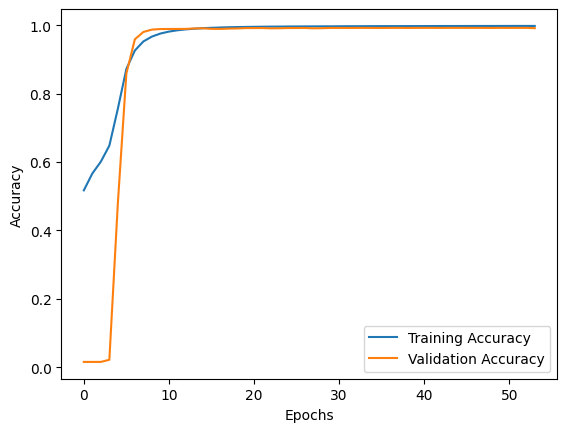

In [53]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

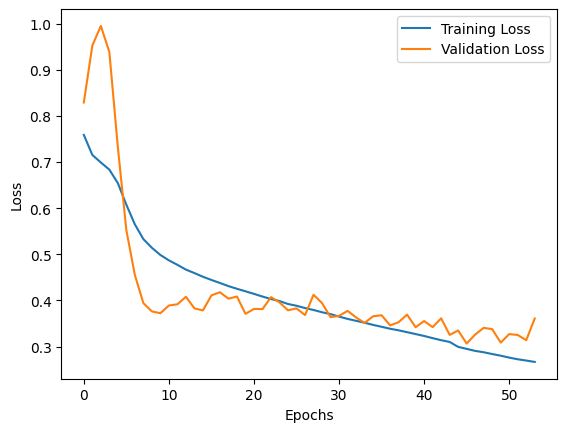

In [54]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
y_pred = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step


In [61]:
y_pred = (y_pred > 0.5).astype(np.uint8)

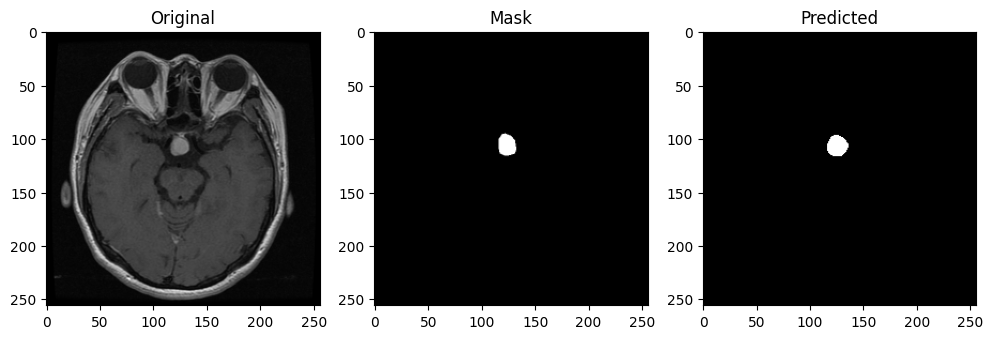

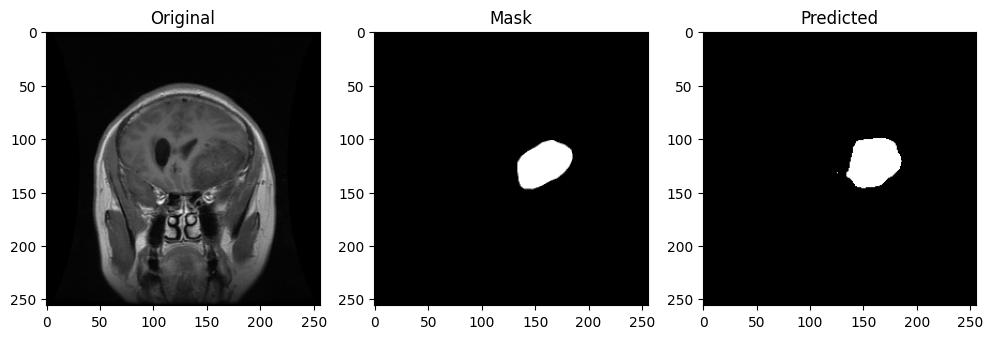

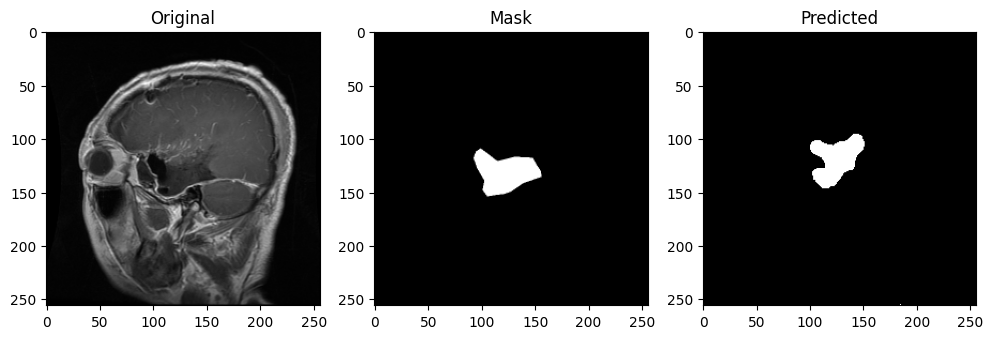

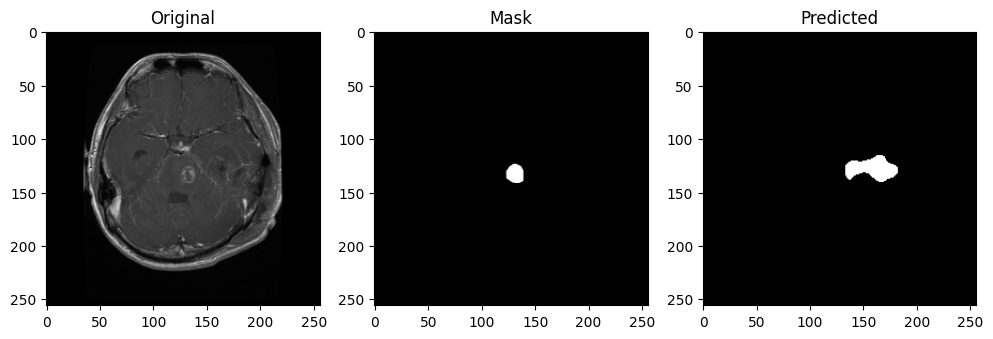

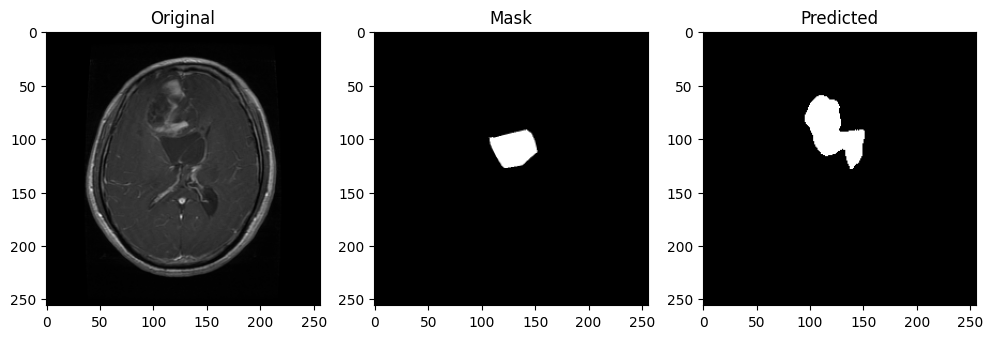

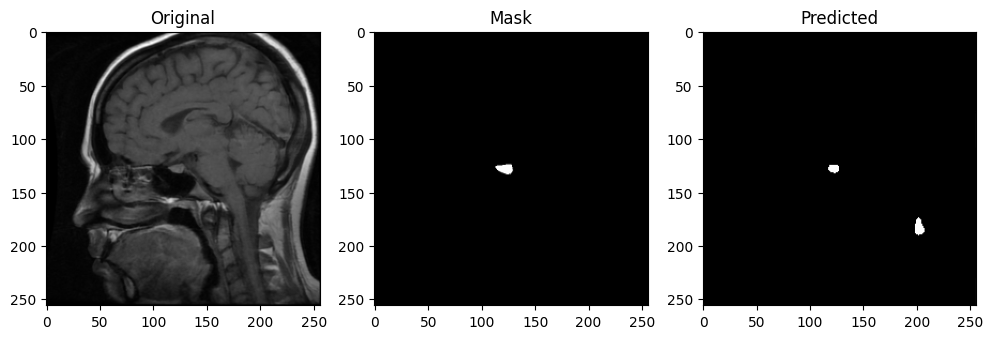

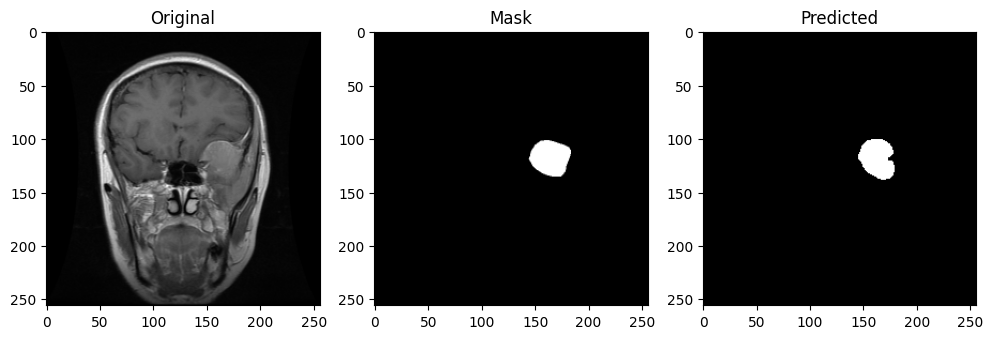

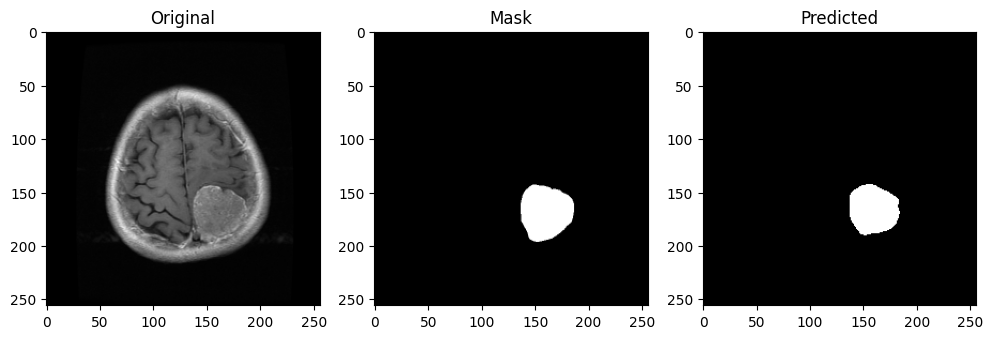

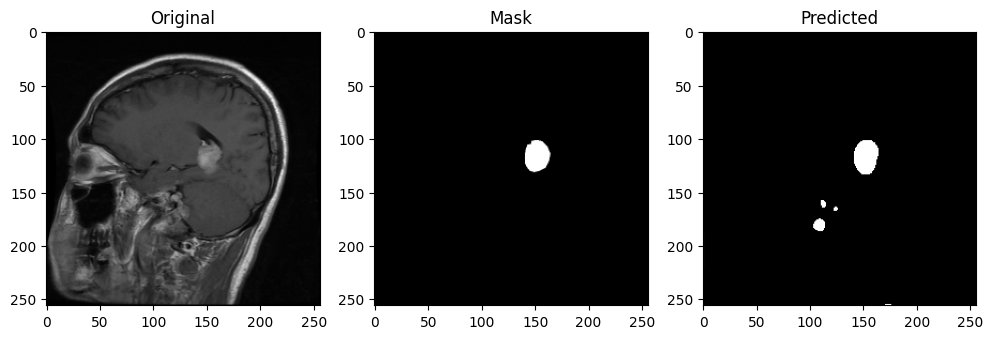

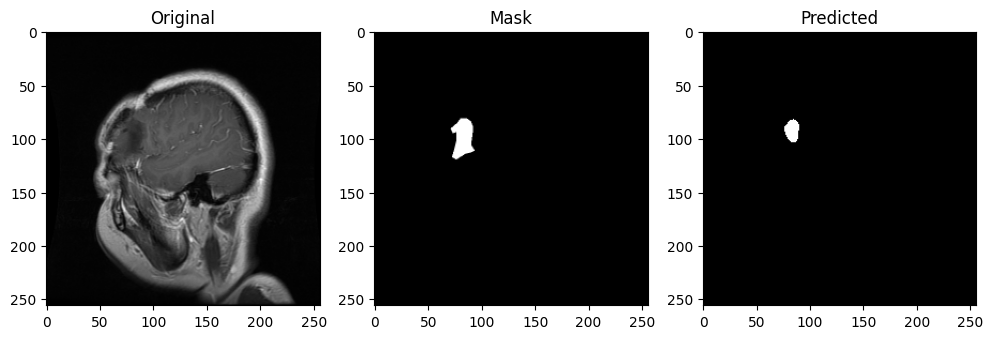

In [67]:
for i in range(10):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(X_test[i], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(y_test[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    plt.imshow(y_pred[i].squeeze(), cmap='gray')

    plt.show()